In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import seaborn as sns

from theano import shared

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [3]:
import sys, IPython, scipy, matplotlib, pandas, seaborn, patsy, platform, theano
print("""This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nArviZ {}\nNumPy {}\nSciPy {}\nPandas {}\nSeaborn {}\nPatsy {}\nMatplotlib {}\nTheano {}\n""".format(sys.version[:5], IPython.__version__, pm.__version__, az.__version__, np.__version__, scipy.__version__, pandas.__version__, seaborn.__version__, patsy.__version__, matplotlib.__version__, theano.__version__))

This notebook was created using:
Python 3.7.4
IPython 7.13.0
PyMC3 3.8
ArviZ 0.7.0
NumPy 1.18.2
SciPy 1.4.1
Pandas 1.0.3
Seaborn 0.10.0
Patsy 0.5.1
Matplotlib 3.2.1
Theano 1.0.4



In [4]:
# load data
d = pd.read_csv("Data/foxes.csv", sep=";", header=0)
d.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


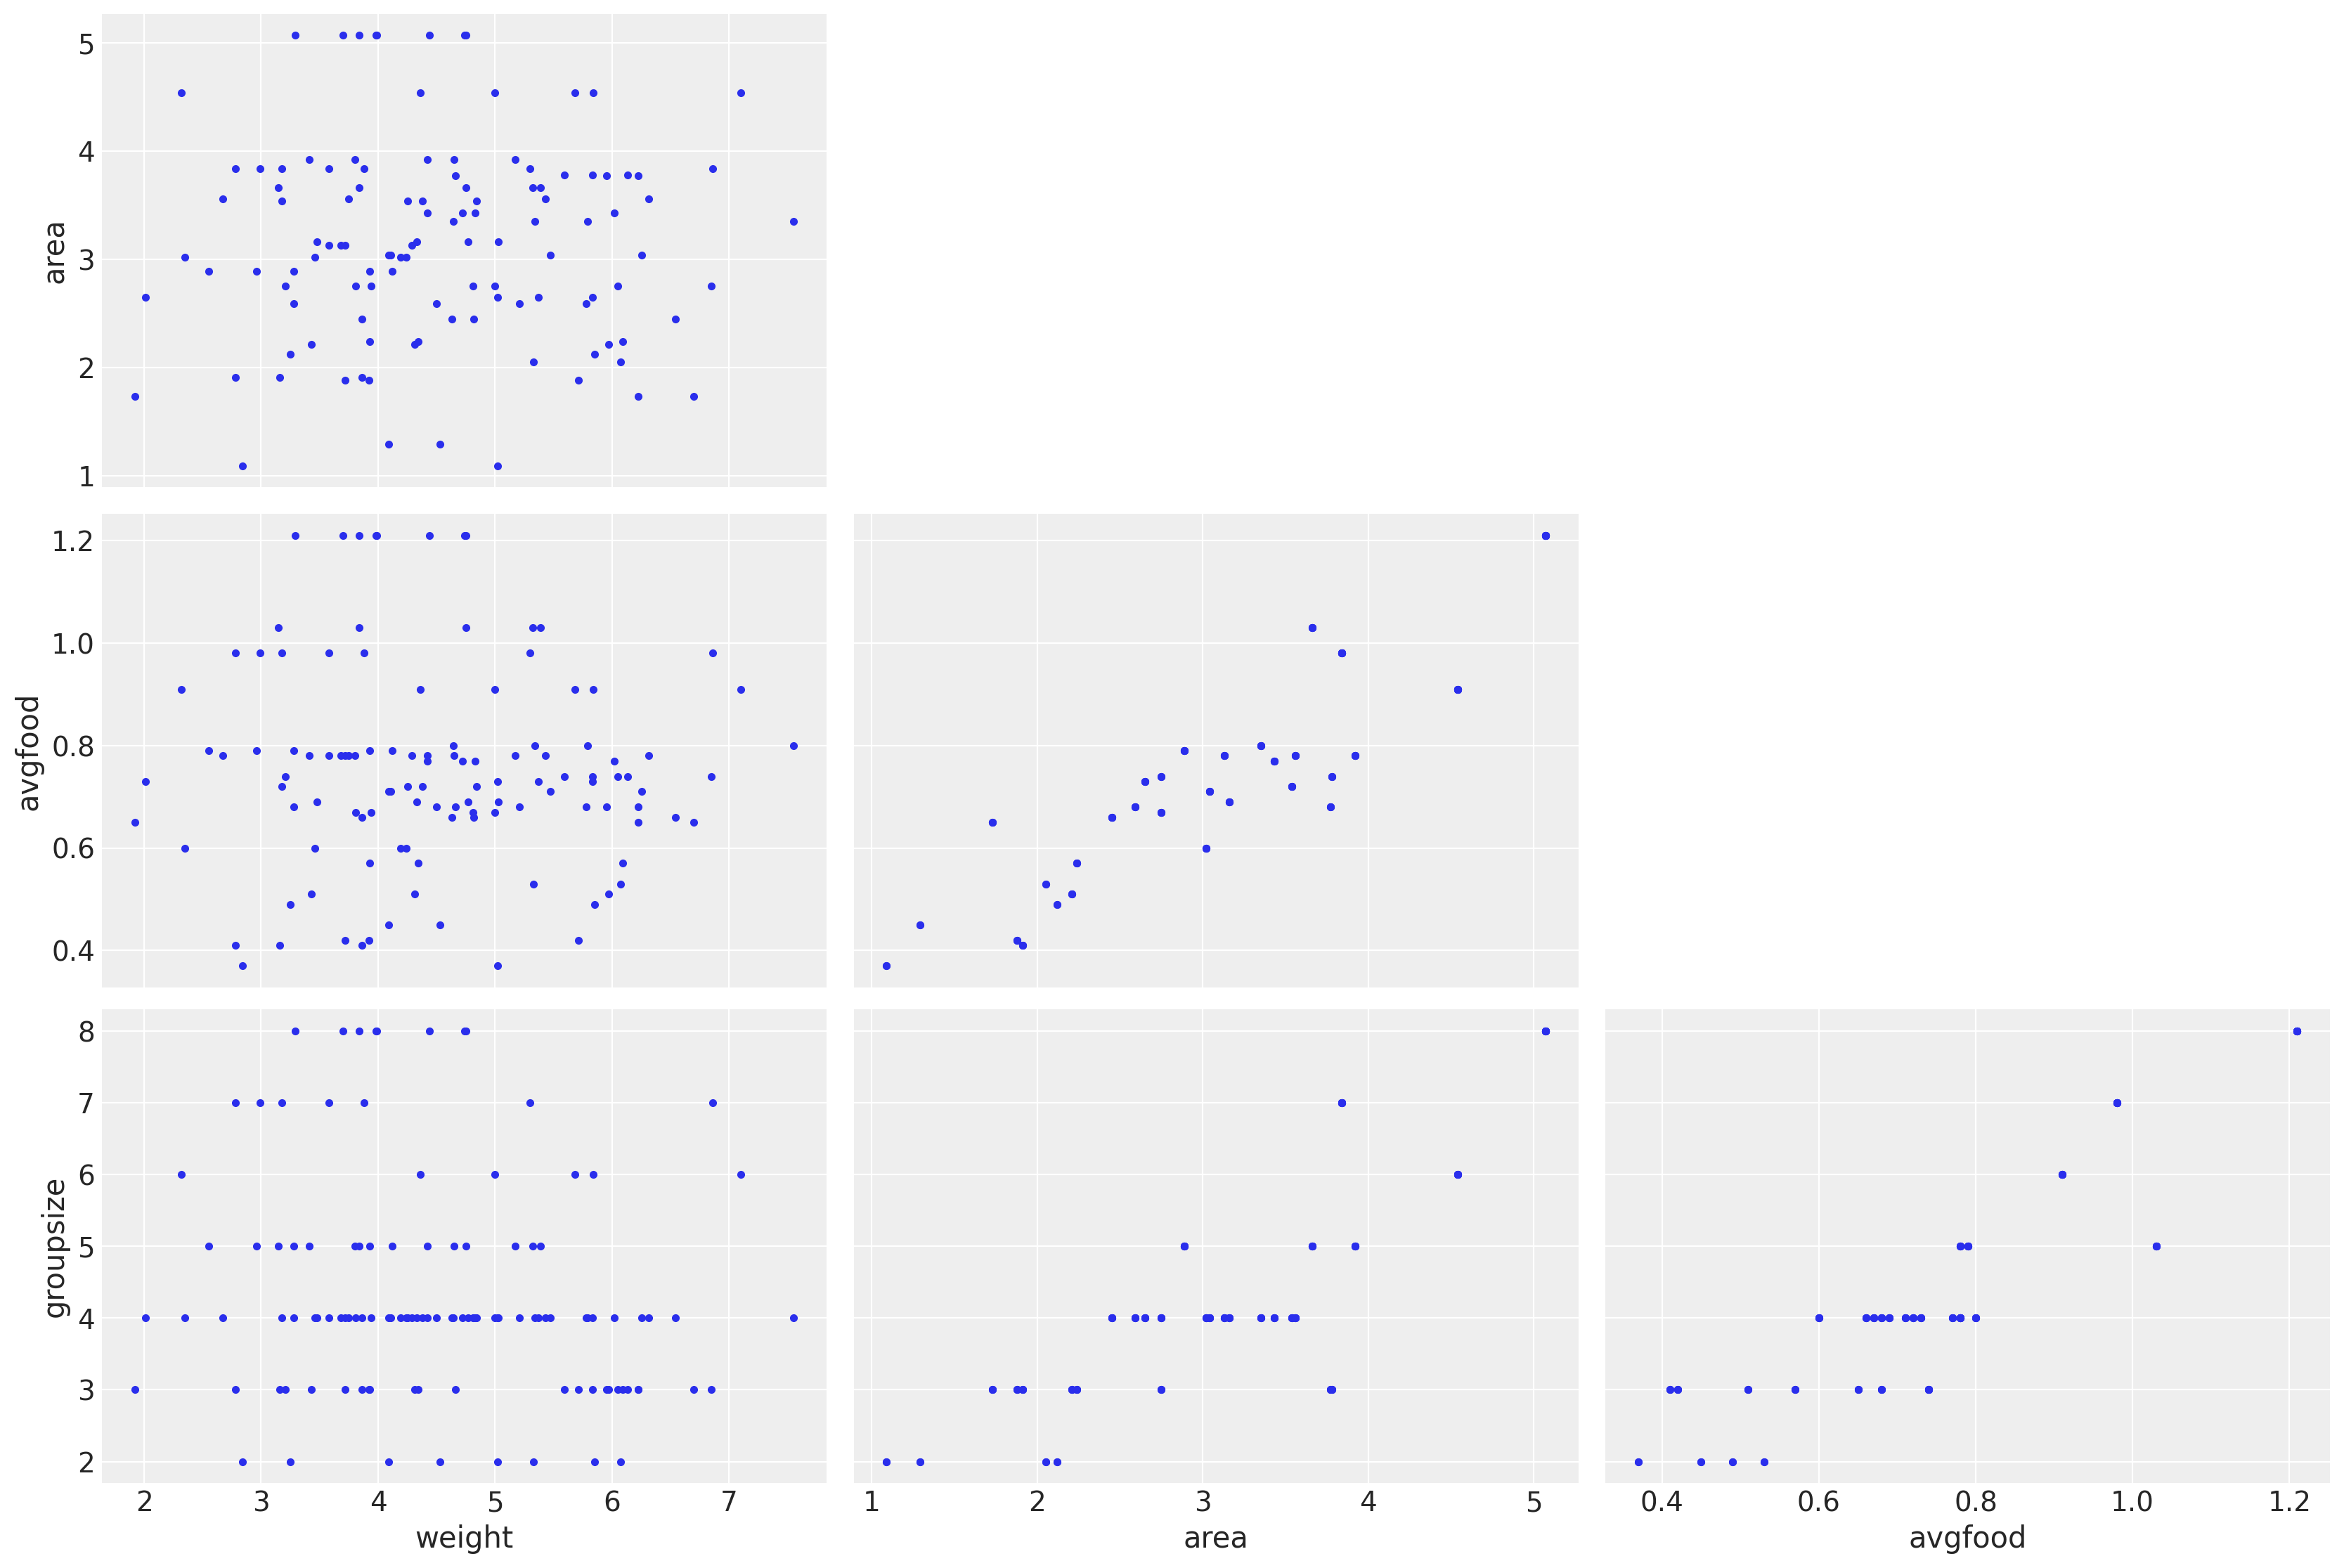

In [5]:
az.plot_pair({"weight":d["weight"], 
              "area":d["area"], 
              "avgfood":d["avgfood"], 
              "groupsize":d["groupsize"]})
plt.show()

In [6]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

In [7]:
# standardize the variables
d['W'] = standardize(d['weight'])
d['A'] = standardize(d['area'])
d['F'] = standardize(d['avgfood'])
d['G'] = standardize(d['groupsize'])
d.head()

,group,avgfood,groupsize,area,weight,W,A,F,G
0,1,0.37,2,1.09,5.02,0.414135,-2.239596,-1.924829,-1.524089
1,1,0.37,2,1.09,2.84,-1.427046,-2.239596,-1.924829,-1.524089
2,2,0.53,2,2.05,5.33,0.675954,-1.205508,-1.118035,-1.524089
3,2,0.53,2,2.05,6.07,1.300942,-1.205508,-1.118035,-1.524089
4,3,0.49,2,2.12,5.85,1.115135,-1.130106,-1.319734,-1.524089


### 1. Use a model to infer the total causal influence of area on weight. Would increasing the area available to each fox make it heavier (healthier)? You might want to standardize the variables. Regardless, use prior predictive simulation to show that your model’s prior predictions stay within the possible outcome range.

In [8]:
# define model: weight ~ area
with pm.Model() as m_foxes_1: 
    a = pm.Normal('a', mu=0, sigma=0.25)
    bA = pm.Normal('bA', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a+bA*d['A'])
    weight = pm.Normal('weight', mu=mu, sd=sigma, observed=d['W'])
    prior_samples = pm.sample_prior_predictive(1000)
    m_foxes_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4850.22draws/s]


In [9]:
# show model summary
varnames = ['~mu']
az.summary(m_foxes_1, varnames, kind="stats",  round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
a,-0.00,0.09,-0.15,0.13
bA,0.02,0.10,-0.13,0.17
sigma,1.01,0.07,0.90,1.12


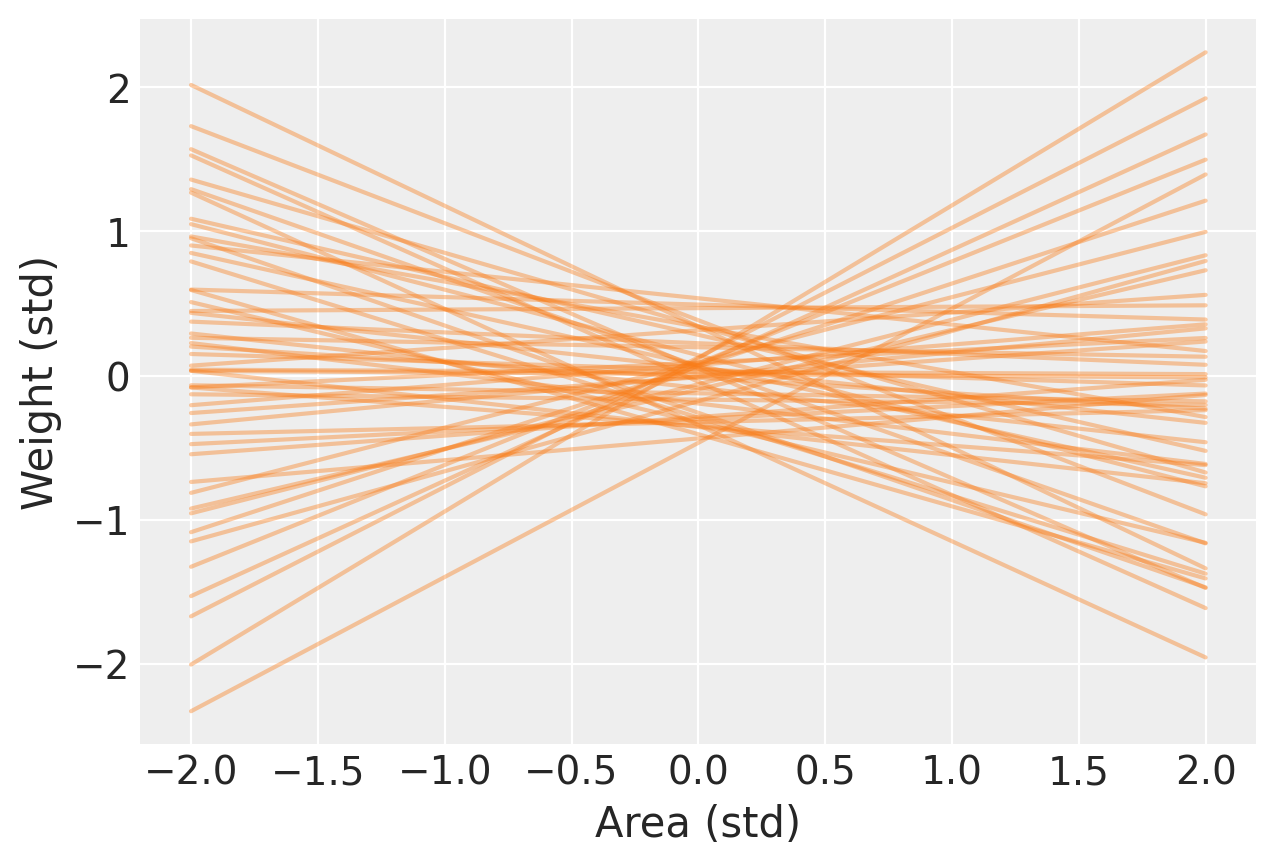

In [10]:
# test priors
x = np.linspace(-2, 2, 50)
for a, bA in zip(prior_samples["a"][:50], prior_samples["bA"][:50]):
    y = a + bA * x
    plt.plot(x, y, '-C1', alpha=0.4)
plt.ylabel('Weight (std)', fontsize=15)
plt.xlabel('Area (std)', fontsize=15)
plt.show()

Territory size seems to have no total causal influence on weight, at least not in this sample.

### 2. Now infer the causal impact of adding food to a territory. Would this make foxes heavier? Which covariates do you need to adjust for to estimate the total causal influence of food?

In [11]:
# define model: weight ~ avgfood  
with pm.Model() as m_foxes_2: 
    a = pm.Normal('a', mu=0, sigma=0.25)
    bF = pm.Normal('bF', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a+bF*d['F'])
    weight = pm.Normal('weight', mu=mu, sd=sigma, observed=d['W'])
    m_foxes_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bF, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 5000.03draws/s]


In [12]:
# show model summary
varnames = ['~mu']
az.summary(m_foxes_2, varnames, kind="stats",  round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
a,0.00,0.09,-0.13,0.15
bF,-0.02,0.09,-0.18,0.12
sigma,1.01,0.07,0.90,1.12


Again nothing. Adding food does not change weight. This shouldn’t surprise you, if the DAG is correct, because area is upstream of avgfood.

### 3. Now infer the causal impact of groupsize. Which covariates do you need to adjust for? Looking at the posterior distribution of the resulting model, what do you think explains these data? That is, can you explain the estimates for all three problems? How do they go together?

In [13]:
# define model: weight ~ avgfood + groupsize 
with pm.Model() as m_foxes_3: 
    a = pm.Normal('a', mu=0, sigma=0.25)
    bF = pm.Normal('bF', mu=0, sd=0.5)
    bG = pm.Normal('bG', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a+bF*d['F']+bG*d['G'])
    weight = pm.Normal('weight', mu=mu, sd=sigma, observed=d['W'])
    m_foxes_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bG, bF, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2828.48draws/s]


In [14]:
# show model summary
varnames = ['~mu']
az.summary(m_foxes_3, varnames, kind="stats",  round_to=2, credible_interval=0.89)

,mean,sd,hpd_5.5%,hpd_94.5%
a,0.00,0.08,-0.13,0.13
bF,0.47,0.18,0.18,0.76
bG,-0.57,0.18,-0.85,-0.27
sigma,0.96,0.06,0.86,1.06


It looks like group size is negatively associated with weight, controlling for food. Similarly, food is positively associated with weight, controlling for group size. So the causal influence of group size is to reduce weight—less food for each fox. And the direct causal influence of food is positive, of course. But the total causal influence of food is still nothing, since it causes larger groups. This is a masking effect, like in the milk energy example. But the causal explanation here is that more foxes move into a territory until the food available to each is no better than the food in a neighboring territory. Every territory ends up equally good/bad on average. This is known in behavioral ecology as an ideal free distribution.